In [1]:
import numpy as np, matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from PIL import Image
import os

In [12]:
# In the repository, only few images from the BSDS500 dataset are provided.
# 
# To reproduce results publsihed in the paper, the full BSDS500 dataset is needed. You can retrieve it 
# by downloading the corresponding repo and placing it in the required location.
# https://github.com/BIDS/BSDS500

In [3]:
def read_img_gray(filepath):
    return Image.open(filepath).convert('L')

def histogram(image):
    histogram = np.zeros((256))
    a = np.reshape(image, (-1))
    for pixel in a:
        histogram[pixel] = histogram[pixel] + 1
    return histogram

def cumulative_arr(arr):
    cumulative_arr = np.zeros((len(arr)))
    if len(arr) == 0:
        return cumulative_arr
    cumulative_arr[0] = arr[0]
    for i in range(1, len(arr)):
        cumulative_arr[i] = cumulative_arr[i-1] + arr[i]
    return cumulative_arr

def probabilitize(histogram):
    return histogram/np.sum(histogram)

def histogram_intensity(histogram):
    histogram_intensity = np.zeros(len(histogram))
    for i in range(len(histogram)):
        histogram_intensity[i] = histogram[i] * i
    return histogram_intensity

def segment_image(im, thresholds, h=None, ch=None, chi=None):
    plotting_boundaries = thresholds + [0, 255]
    plotting_boundaries.sort()

    h = histogram(im) if h is None else h
    ch = cumulative_arr(h) if ch is None else ch
    chi = cumulative_arr(histogram_intensity(h)) if chi is None else chi

    out = im.point(lambda x: x)
    for i in range(len(plotting_boundaries) - 1):
        t1, t2 = plotting_boundaries[i], plotting_boundaries[i + 1]
        nom = chi[t2] - chi[t1] if t1 > 0 else chi[t2]
        den = ch[t2] - ch[t1] if t1 > 0 else ch[t2]
        ui = int(nom / den) if den > 0 else (t1 + t2) // 2
        out = out.point(lambda x: ui if (t1 <= x < t2) or (x == t2 == 255) else x, mode='L')
    return out

In [4]:
class Otsu:
    def __init__(self, h):
        ph = probabilitize(h)
        self.__arr = -np.ones((256, 256))
        self.__cph = cumulative_arr(ph)
        phi = histogram_intensity(ph)
        self.__cphi = cumulative_arr(phi)
        self.__n_T = self.__cph[-1]
        self.__u_T = self.__cphi[-1] / self.__n_T
        self.name = 'Otsu'
        self.dir = 'max'
    def get(self, st, en):
        if self.__arr[st, en]==-1:
            self.__arr[st, en] = self.calc_s(st, en)
        return self.__arr[st, en]
    def calc_s(self, st, en):
        w_i = (self.__cph[en] - self.__cph[st - 1]) if st > 0 else self.__cph[en]
        x = self.__cphi[en] - self.__cphi[st - 1] if st > 0 else self.__cphi[en]
        u_i = x / w_i if w_i != 0 else x
        sig_i = w_i * (u_i - self.__u_T) ** 2
        return sig_i

In [5]:
class Kapur:
    def __init__(self, h):
        ph = probabilitize(h)
        self.cph = cumulative_arr(ph)
        self.c_ph_lg = cumulative_arr(np.multiply(ph, np.log(ph, out=np.zeros_like(ph), where=(ph != 0))))
        self.arr = -np.ones((256,256))
        self.name='Kapur'
        self.dir = 'max'
    def get(self, st, en):
        if self.arr[st, en]==-1:
            self.arr[st, en] = self.entropy(st, en)
        return self.arr[st, en]
    def entropy(self, st, en):
        if en == -1:
            return -np.inf
        w_i = self.cph[en] - self.cph[st - 1] if st > 0 else self.cph[en]
        F1 = np.log(w_i, out=np.zeros_like(w_i), where=(w_i != 0))
        F2 = ((self.c_ph_lg[en] - self.c_ph_lg[st - 1]) / w_i if st > 0 else self.c_ph_lg[en] / w_i ) if w_i>0 else 0
        h_i = F1 - F2 if w_i>0 else 0#-1e5 #-np.inf # h_i = F1 - F2
        return h_i

In [6]:
def nrm(a):
    x = np.array(a)
    return (x-x.min())/(x.max()-x.min())

In [7]:
def listdir_path(path):
    l1 = list(map(lambda x: (x, path + os.sep + x), os.listdir(path)))
    l2 = list(filter(lambda x: x[1].endswith('.jpg') or x[1].endswith('.png'), l1))
    return l2
    
BSDS500 = {'train': listdir_path('BSDS500/BSDS500/data/images/train'),
           'test': listdir_path('BSDS500/BSDS500/data/images/test'),
           'val': listdir_path('BSDS500/BSDS500/data/images/val'),
           'train_path': 'BSDS500/BSDS500/data/images/train/',
           'test_path': 'BSDS500/BSDS500/data/images/test/',
           'val_path': 'BSDS500/BSDS500/data/images/val/'
           }
BSDS500_all = BSDS500['train'] + BSDS500['test'] + BSDS500['val']

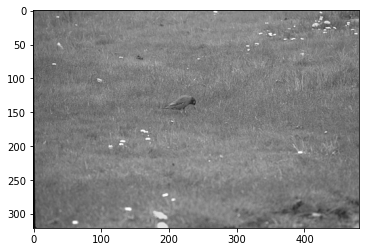

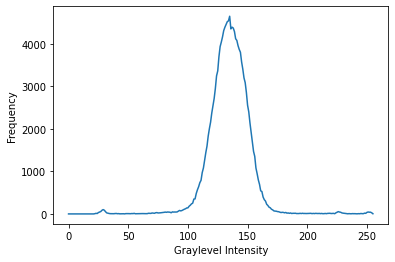

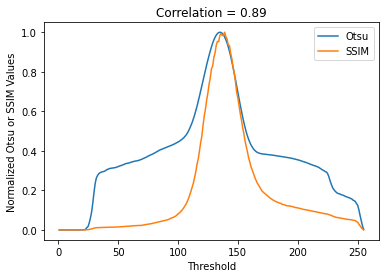

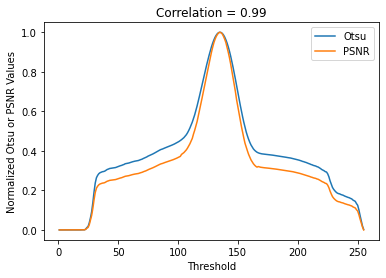

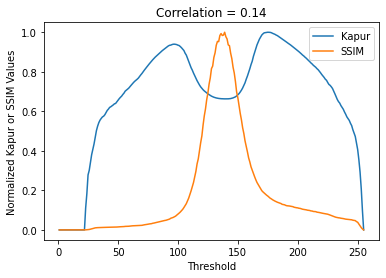

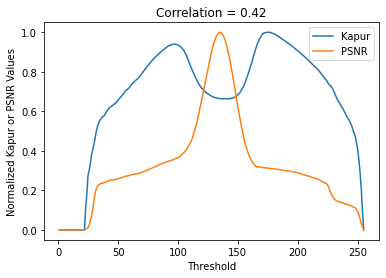

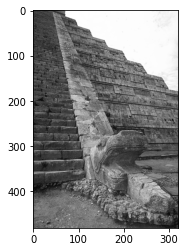

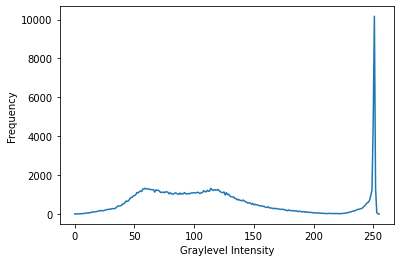

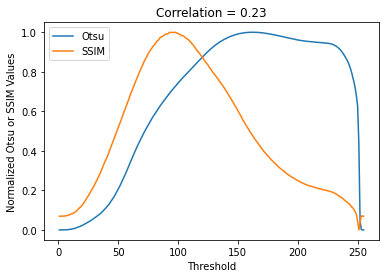

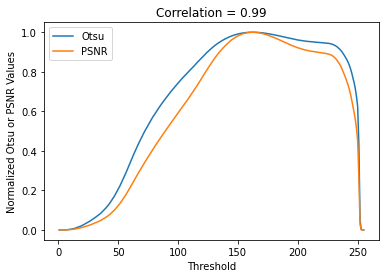

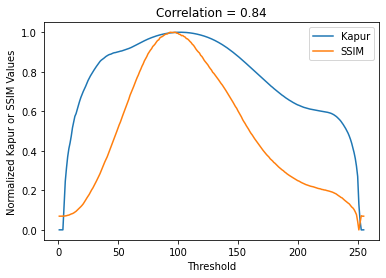

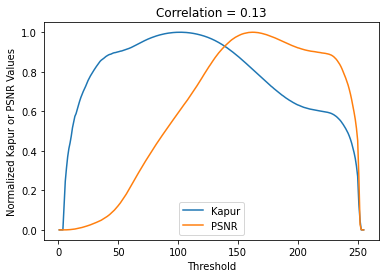

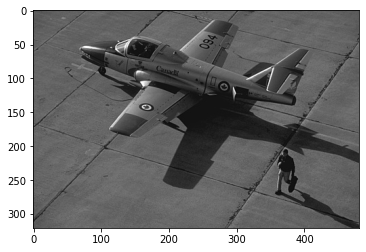

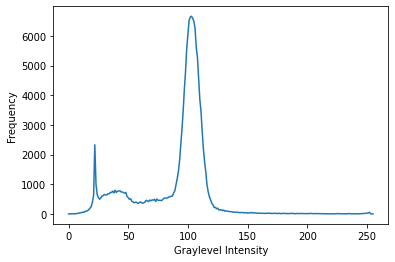

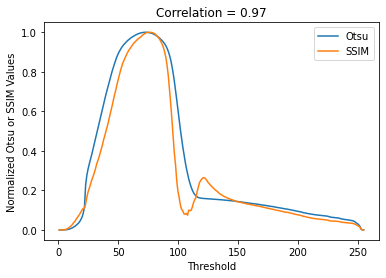

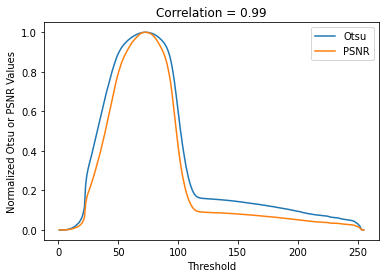

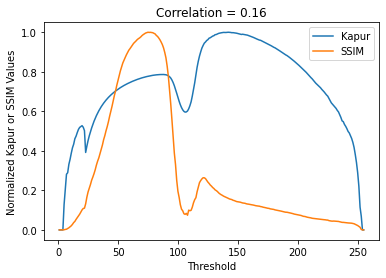

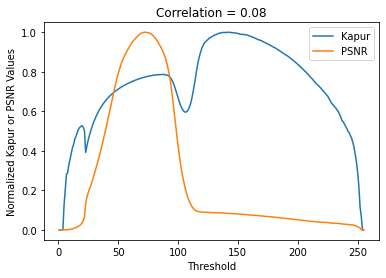

In [8]:
d = dict(BSDS500_all)
samples = ['28096', '33044', '37073']
for sample in samples:
    img_name, img_path = sample+'.jpg', d[sample+'.jpg']
    otsus, kapurs, ssims, psnrs = [], [], [], []
    img = read_img_gray(img_path)
    h = histogram(img)
    ph = probabilitize(h)
    ot = Otsu(ph)
    ka = Kapur(ph)
    for t in range(1, 256):
        otsus.append(ot.get(0, t - 1) + ot.get(t, 255))
        kapurs.append(ka.get(0, t - 1) + ka.get(t, 255))
        img2 = segment_image(img, [t])
        ssims.append(ssim(np.array(img), np.array(img2)))
        psnrs.append(psnr(np.array(img), np.array(img2)))
    xs = np.arange(1, 256)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(h)
    plt.xlabel('Graylevel Intensity')
    plt.ylabel('Frequency')
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(xs, nrm(otsus), label='Otsu')
    plt.plot(xs, nrm(ssims), label='SSIM')
    plt.xlabel('Threshold')
    plt.ylabel('Normalized Otsu or SSIM Values')
    plt.legend()
    plt.title('Correlation = {:.2f}'.format(np.corrcoef(otsus, ssims)[0][1]))
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(xs, nrm(otsus), label='Otsu')
    plt.plot(xs, nrm(psnrs), label='PSNR')
    plt.xlabel('Threshold')
    plt.ylabel('Normalized Otsu or PSNR Values')
    plt.legend()
    plt.title('Correlation = {:.2f}'.format(np.corrcoef(otsus, psnrs)[0][1]))
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(xs, nrm(kapurs), label='Kapur')
    plt.plot(xs, nrm(ssims), label='SSIM')
    plt.xlabel('Threshold')
    plt.ylabel('Normalized Kapur or SSIM Values')
    plt.legend()
    plt.title('Correlation = {:.2f}'.format(np.corrcoef(kapurs, ssims)[0][1]))
    plt.show()
    plt.close()
    plt.figure()
    plt.plot(xs, nrm(kapurs), label='Kapur')
    plt.plot(xs, nrm(psnrs), label='PSNR')
    plt.xlabel('Threshold')
    plt.ylabel('Normalized Kapur or PSNR Values')
    plt.legend()
    plt.title('Correlation = {:.2f}'.format(np.corrcoef(kapurs, psnrs)[0][1]))
    plt.show()
    plt.close()

In [9]:
print('\t'.join(['name', 'Otsu_SSIM', 'Otsu_PSNR', 'Kapur_SSIM', 'Kapur_PSNR']))
for img_name, img_path in BSDS500_all:
    otsus, kapurs, ssims, psnrs = [], [], [], []
    img = read_img_gray(img_path)
    h = histogram(img)
    ph = probabilitize(h)
    ot = Otsu(ph)
    ka = Kapur(ph)
    for t in range(1, 256):
        otsus.append(ot.get(0, t - 1) + ot.get(t, 255))
        kapurs.append(ka.get(0, t - 1) + ka.get(t, 255))
        img2 = segment_image(img, [t])
        ssims.append(ssim(np.array(img), np.array(img2)))
        psnrs.append(psnr(np.array(img), np.array(img2)))
    print(img_name, end='\t')
    print(np.corrcoef(otsus, ssims)[0, 1], end='\t')
    print(np.corrcoef(otsus, psnrs)[0, 1], end='\t')
    print(np.corrcoef(kapurs, ssims)[0, 1], end='\t')
    print(np.corrcoef(kapurs, psnrs)[0, 1])

name	Otsu_SSIM	Otsu_PSNR	Kapur_SSIM	Kapur_PSNR
28096.jpg	0.8851034208191378	0.9946969790799718	0.14439470189454948	0.4163841489438354
33044.jpg	0.22621353103823189	0.9881553337678746	0.8387093744813706	0.13466509805199967
33039.jpg	0.9847391872035408	0.987201455814798	0.863712705061008	0.8137674789157981
37073.jpg	0.9650272650679927	0.9911811371080596	0.1592649217706505	0.08054087089903239
38082.jpg	0.9733634752567973	0.9922114123890208	0.6688125585605648	0.7049720261536087


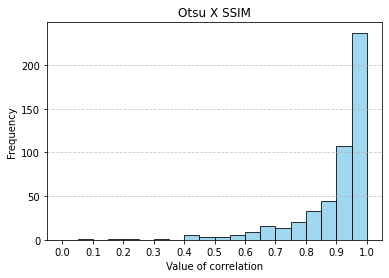

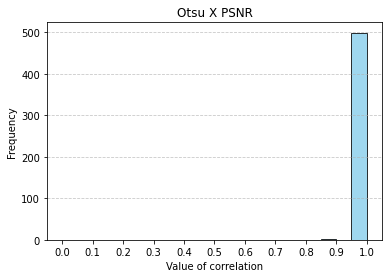

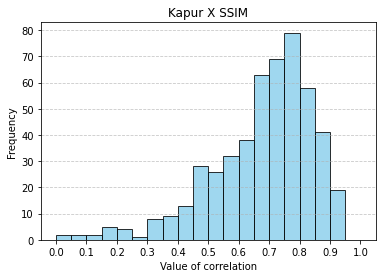

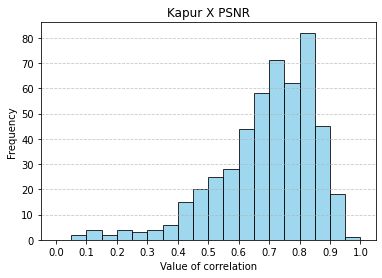

In [10]:
a = [
    ('Otsu X SSIM',
     [0.786204131, 0.923116249, 0.925965325, 0.92889465, 0.990026574, 0.961835783, 0.885103421, 0.965027265,
      0.623035982, 0.761204065, 0.879931828, 0.94708858, 0.990782144, 0.92602885, 0.662286254, 0.946075191, 0.917213198,
      0.858522667, 0.968624082, 0.509622486, 0.796391039, 0.448745522, 0.053004849, 0.869515658, 0.807375999,
      0.794660446, 0.911623971, 0.97105634, 0.885322511, 0.810886686, 0.986330455, 0.642698845, 0.902849357,
      0.565020788, 0.982357607, 0.973019198, 0.743815101, 0.669851867, 0.435599854, 0.928097472, 0.976704896,
      0.986740411, 0.949802749, 0.975443633, 0.848529708, 0.997485701, 0.877347152, 0.872889147, 0.837449526,
      0.862134535, 0.920346303, 0.932320396, 0.981632585, 0.978017524, 0.997597354, 0.910512013, 0.892206852,
      0.93297737, 0.93833344, 0.981836497, 0.872389574, 0.910000162, 0.843683455, 0.8684255, 0.988306959, 0.461482262,
      0.974963932, 0.332391345, 0.994012557, 0.971153948, 0.427029832, 0.91006038, 0.94997268, 0.892959072, 0.594320161,
      0.99817125, 0.970836382, 0.809402508, 0.946629195, 0.923538259, 0.930582482, 0.959583429, 0.678513117,
      0.432205404, 0.776830727, 0.963915916, 0.659897852, 0.743639829, 0.925551113, 0.988589826, 0.785759823,
      0.691203553, 0.964780916, 0.922702815, 0.958194469, 0.998704166, 0.990491267, 0.707259808, 0.98654446,
      0.853540962, 0.970020153, 0.95152473, 0.843067661, 0.930685086, 0.979074554, 0.989840572, 0.725260759,
      0.906282634, 0.932266455, 0.707113998, 0.919731906, 0.85249361, 0.915511158, 0.876417171, 0.956035733,
      0.909899238, 0.986979991, 0.993184349, 0.837215912, 0.730474993, 0.657827394, 0.87811839, 0.820140855,
      0.789948746, 0.667124711, 0.936801907, 0.978716353, 0.988729979, 0.935703952, 0.982999893, 0.880633957,
      0.999111242, 0.965979544, 0.993783909, 0.902718726, 0.896789748, 0.989138225, 0.919712667, 0.928350812,
      0.947550281, 0.846560847, 0.799375412, 0.985830503, 0.748976166, 0.959729125, 0.970683579, 0.801703401,
      0.889252416, 0.996817448, 0.827758382, 0.992837782, 0.932849191, 0.995577501, 0.943243342, 0.864096524,
      0.983592376, 0.967371654, 0.787672019, 0.99697008, 0.95028547, 0.859353275, 0.748640928, 0.656382088, 0.954111746,
      0.98012684, 0.88320679, 0.992521147, 0.971080666, 0.986761546, 0.988308316, 0.97100406, 0.940005985, 0.996840044,
      0.990977509, 0.93922307, 0.99275641, 0.634484145, 0.977592058, 0.751555283, 0.766992922, 0.974303542, 0.951624637,
      0.933343293, 0.860731602, 0.962387108, 0.984395905, 0.917714259, 0.986941401, 0.836208091, 0.972518434,
      0.986993398, 0.978629481, 0.978757247, 0.973363475, 0.923281254, 0.979249117, 0.623616675, 0.915088336,
      0.993841942, 0.981885607, 0.984935221, 0.724443703, 0.958670262, 0.980227086, 0.466834609, 0.982888276,
      0.98337874, 0.960949967, 0.992560118, 0.610312934, 0.949477085, 0.951767522, 0.684458577, 0.832141763,
      0.992331309, 0.826227067, 0.970604724, 0.645332839, 0.965436385, 0.764879385, 0.906508999, 0.956299135,
      0.933230416, 0.944084596, 0.888730103, 0.87709133, 0.697600266, 0.902482967, 0.974177078, 0.979469381,
      0.913357167, 0.974743477, 0.945207331, 0.948106375, 0.979111503, 0.977602969, 0.984365899, 0.524381729,
      0.842518091, 0.965477818, 0.821481377, 0.864936689, 0.979130523, 0.793748606, 0.818754986, 0.947991698,
      0.97888504, 0.864450379, 0.824201309, 0.98504271, 0.860315375, 0.803745987, 0.90720089, 0.695185623, 0.872108647,
      0.912292983, 0.994333519, 0.952304127, 0.850776201, 0.945274931, 0.970638147, 0.984605997, 0.909481182,
      0.756000622, 0.946351964, 0.923664505, 0.954736593, 0.983465043, 0.92841618, 0.67978269, 0.968940377, 0.976384506,
      0.96864569, 0.989028993, 0.730306988, 0.713467623, 0.934719679, 0.951852157, 0.970046001, 0.986491831,
      0.725379183, 0.911101707, 0.942215486, 0.979900524, 0.949459434, 0.425987898, 0.983511865, 0.789438629,
      0.945102532, 0.965365946, 0.837038175, 0.980711208, 0.599385211, 0.98721902, 0.947838351, 0.471012072,
      0.942599102, 0.890769729, 0.835497084, 0.994860937, 0.802248527, 0.991187539, 0.951886993, 0.993970084,
      0.924982954, 0.982088976, 0.970351701, 0.998614443, 0.849316216, 0.6959805, 0.96445499, 0.897959255, 0.987488634,
      0.993294855, 0.937243392, 0.982950661, 0.992042811, 0.942547137, 0.98681083, 0.805224262, 0.801445631,
      0.962005873, 0.931135062, 0.984348544, 0.171527972, 0.699144862, 0.878331595, 0.960707547, 0.979751082,
      0.922694612, 0.97222327, 0.991409147, 0.954533629, 0.984969068, 0.848220396, 0.866739906, 0.973539381,
      0.907481069, 0.924558626, 0.991954472, 0.856423395, 0.934208653, 0.931842297, 0.958447642, 0.986802293,
      0.972247061, 0.928581535, 0.948581291, 0.907599428, 0.878961846, 0.935696171, 0.899694506, 0.95273771,
      0.551544383, 0.805388266, 0.774997579, 0.873335123, 0.835479749, 0.60908254, 0.931899766, 0.977760538,
      0.992969498, 0.961900579, 0.830860543, 0.976237808, 0.97949209, 0.709261678, 0.956028536, 0.756087352, 0.98362208,
      0.954787431, 0.937365493, 0.754934074, 0.964118105, 0.982859924, 0.995631197, 0.961897127, 0.97933665,
      0.521775533, 0.904642284, 0.977683189, 0.996217613, 0.988664011, 0.615865921, 0.968952735, 0.975126596,
      0.694346741, 0.921552383, 0.979612376, 0.996474464, 0.973909901, 0.878951542, 0.947279768, 0.989436165,
      0.967488813, 0.990245154, 0.976930919, 0.940321878, 0.990387715, 0.786364494, 0.994266333, 0.9778204, 0.969144272,
      0.909593897, 0.894160423, 0.951265603, 0.983568047, 0.961754168, 0.973077628, 0.992240453, 0.9773384, 0.98280129,
      0.994518345, 0.948034369, 0.979958825, 0.991094853, 0.968859325, 0.97300152, 0.929975886, 0.740935367,
      0.973238852, 0.973293571, 0.988167683, 0.907611706, 0.591029854, 0.945974282, 0.226213531, 0.986210861,
      0.976245316, 0.960530899, 0.923690658, 0.967971728, 0.981319508, 0.981604622, 0.957213869, 0.990784706,
      0.904176746, 0.967575042, 0.961744195, 0.989154738, 0.962393159, 0.949923522, 0.801632909, 0.983132489,
      0.875356108, 0.91277402, 0.922854708, 0.864579068, 0.972524773, 0.973034875, 0.889764002, 0.984739187,
      0.951676092, 0.982192131, 0.989434475, 0.965832658, 0.995800789, 0.828645274, 0.925493611, 0.89665792,
      0.961395377, 0.983265622, 0.954805327, 0.959497276, 0.912189154, 0.901390568, 0.982852418, 0.997196243,
      0.987569676, 0.622823301, 0.949281672, 0.979924064, 0.994805399, 0.944054219, 0.986593531, 0.936472179,
      0.975937743, 0.970462173, 0.984496125, 0.964258382, 0.988300725, 0.970992536, 0.964916282, 0.93974992,
      0.990894497, 0.99354574, 0.989180332, 0.965063187, 0.992649808, 0.950863468, 0.975638755, 0.692697424,
      0.935963782, 0.822042068, 0.971674661, 0.766238093, 0.984430399, 0.907304021, 0.921431997, 0.940744647]),
    ('Otsu X PSNR',
     [0.98375996, 0.986627098, 0.99049447, 0.990710775, 0.991999068, 0.992608734, 0.994696979, 0.991181137, 0.995812106,
      0.988013682, 0.989497798, 0.973783433, 0.989074475, 0.994421516, 0.978694, 0.984344193, 0.974927751, 0.994455431,
      0.995315065, 0.991030599, 0.979577672, 0.996193607, 0.99397936, 0.996531479, 0.984231351, 0.997357618, 0.99536356,
      0.995194968, 0.990972152, 0.993986368, 0.992307152, 0.998636474, 0.969516638, 0.995105073, 0.985459965,
      0.989504124, 0.992879367, 0.983162215, 0.979891794, 0.993695193, 0.993702082, 0.994279255, 0.989084327,
      0.992017473, 0.982668075, 0.992235517, 0.992396869, 0.988107291, 0.992791519, 0.994792112, 0.993142682,
      0.991316714, 0.992086927, 0.985462225, 0.982175454, 0.992750736, 0.995527486, 0.982817633, 0.977505931,
      0.992249413, 0.992493576, 0.982360697, 0.983988345, 0.99511112, 0.991473684, 0.988188002, 0.987983187,
      0.983309161, 0.994294619, 0.99231292, 0.984602387, 0.989703473, 0.990662686, 0.99313055, 0.994542641, 0.993782248,
      0.993395156, 0.995362571, 0.993640576, 0.988287669, 0.990049084, 0.992373241, 0.993394636, 0.986809379, 0.9772767,
      0.992899391, 0.987053529, 0.992998163, 0.987166686, 0.991177072, 0.980535577, 0.990312195, 0.986930066,
      0.994187599, 0.993832916, 0.993543438, 0.986672275, 0.985618664, 0.993724016, 0.990849402, 0.992019958,
      0.979608299, 0.993686817, 0.991708946, 0.991973045, 0.992940812, 0.980421459, 0.990877165, 0.991094285,
      0.988477907, 0.992597734, 0.990426384, 0.992073242, 0.978808867, 0.977723429, 0.986775212, 0.974040222,
      0.984987242, 0.989983079, 0.997341089, 0.987947444, 0.985868925, 0.993082257, 0.985575818, 0.983496806,
      0.986735117, 0.992525823, 0.993182382, 0.992567546, 0.979352553, 0.989001439, 0.988135731, 0.992893579,
      0.986024841, 0.986127728, 0.977197869, 0.993267631, 0.987684387, 0.989678033, 0.869923248, 0.991797133,
      0.986390486, 0.991141067, 0.991914458, 0.993640399, 0.983542653, 0.98788175, 0.990659109, 0.993567389,
      0.989952136, 0.988189346, 0.983247824, 0.991822418, 0.989668689, 0.982541391, 0.993024699, 0.986578157,
      0.984531335, 0.99240863, 0.981206311, 0.987758524, 0.989413786, 0.992900882, 0.993742038, 0.985633055,
      0.981547794, 0.988623578, 0.989562237, 0.990567052, 0.991315218, 0.988903303, 0.980932586, 0.991829582,
      0.991940948, 0.9950221, 0.992427912, 0.979620969, 0.995879884, 0.991884833, 0.988835706, 0.990104603, 0.994112466,
      0.98961193, 0.993209596, 0.988084145, 0.978712597, 0.982991622, 0.990778636, 0.9929997, 0.991213281, 0.988292895,
      0.987235133, 0.992192977, 0.992211412, 0.980692088, 0.988084955, 0.987359214, 0.993805046, 0.992465239,
      0.987648793, 0.988125124, 0.973558046, 0.993230429, 0.983611001, 0.982215985, 0.992254167, 0.990580135,
      0.989859732, 0.991598037, 0.987486727, 0.991397517, 0.988168445, 0.982207807, 0.991823829, 0.990910896,
      0.994212566, 0.99065558, 0.979353496, 0.983446329, 0.982031044, 0.987948054, 0.990659205, 0.98593396, 0.988780537,
      0.959198642, 0.983084079, 0.983919121, 0.981692526, 0.986071525, 0.972662104, 0.987533032, 0.985666544,
      0.993705655, 0.989901182, 0.989698797, 0.988831954, 0.982943535, 0.988073301, 0.99175738, 0.990438276,
      0.982885669, 0.985356389, 0.989296969, 0.99049892, 0.979526746, 0.986855257, 0.988363692, 0.991204046, 0.98925844,
      0.986028179, 0.990276845, 0.990346091, 0.992494584, 0.993536077, 0.95460946, 0.985999523, 0.991902074,
      0.991339223, 0.994701174, 0.968353362, 0.98547012, 0.987912998, 0.990641159, 0.98164381, 0.993422993, 0.983532845,
      0.992487684, 0.99253902, 0.99091778, 0.979672638, 0.988882953, 0.991695248, 0.989153991, 0.982100321, 0.989114564,
      0.989951904, 0.984737102, 0.992120855, 0.98788432, 0.98696919, 0.995299173, 0.98947867, 0.987933729, 0.991805639,
      0.969769209, 0.990884817, 0.987049719, 0.987996883, 0.983963512, 0.981153707, 0.991776246, 0.990427221,
      0.984411681, 0.987717856, 0.984208329, 0.9828687, 0.97869333, 0.984161108, 0.978746777, 0.988743673, 0.992217738,
      0.995697773, 0.990718808, 0.989076995, 0.980312304, 0.989522305, 0.989606564, 0.987596949, 0.981408757,
      0.985840924, 0.991775453, 0.993839655, 0.979328566, 0.989205941, 0.991612196, 0.98475042, 0.988024613,
      0.980170905, 0.985919561, 0.989947725, 0.996694772, 0.988463998, 0.989410194, 0.986792809, 0.982492057,
      0.970451815, 0.97948662, 0.986886474, 0.98207464, 0.991491037, 0.97419262, 0.983681609, 0.984021251, 0.988318469,
      0.983403246, 0.987220851, 0.991739458, 0.991478371, 0.992795985, 0.986999849, 0.978156746, 0.988600251,
      0.987390358, 0.991781831, 0.987891449, 0.98131777, 0.978516695, 0.986205654, 0.992474613, 0.992495475,
      0.988880335, 0.986526909, 0.983442452, 0.981752404, 0.976484962, 0.986767121, 0.981726712, 0.980097149,
      0.981176797, 0.983463649, 0.979104207, 0.987044489, 0.98400143, 0.985795056, 0.994372853, 0.989817489,
      0.991985466, 0.989072263, 0.99211227, 0.98795985, 0.98413161, 0.986405519, 0.994163389, 0.991484104, 0.992626862,
      0.991190295, 0.99014258, 0.979887441, 0.986408132, 0.989276911, 0.986567671, 0.976395198, 0.988033191,
      0.990148531, 0.988001499, 0.985531758, 0.97968031, 0.982692357, 0.98360433, 0.989342861, 0.98969771, 0.989284239,
      0.987700045, 0.989497177, 0.983032166, 0.984312248, 0.986890252, 0.987985827, 0.984683413, 0.990091931,
      0.989433519, 0.991424317, 0.987047485, 0.992267612, 0.980883869, 0.99172516, 0.985006415, 0.980923254,
      0.984733178, 0.988748327, 0.98927499, 0.988753549, 0.987341059, 0.985449848, 0.981318945, 0.981840749,
      0.982113085, 0.987538571, 0.994505741, 0.986390924, 0.993413369, 0.973950604, 0.981476956, 0.988186808,
      0.981662824, 0.986746501, 0.988155334, 0.986473596, 0.985156829, 0.983010787, 0.992478593, 0.986542943,
      0.981624339, 0.985199589, 0.991612825, 0.979053376, 0.986310037, 0.990106206, 0.972550704, 0.987888179,
      0.983491775, 0.986772715, 0.986453419, 0.985225152, 0.965964208, 0.976644671, 0.988948934, 0.986081515,
      0.980445117, 0.984786354, 0.987103196, 0.987201456, 0.987313196, 0.992728118, 0.978649144, 0.986832095,
      0.983725594, 0.975616797, 0.98015, 0.994831742, 0.992042695, 0.980204131, 0.983167289, 0.984341272, 0.988739524,
      0.98673497, 0.982443815, 0.98697859, 0.983569395, 0.973733048, 0.987228807, 0.991519587, 0.988606962, 0.986905812,
      0.984068999, 0.987705394, 0.985582304, 0.974759556, 0.979621216, 0.988592144, 0.98931228, 0.982041785,
      0.988271689, 0.988096894, 0.970086943, 0.978308313, 0.986144548, 0.988665435, 0.97878233, 0.985998765,
      0.982072992, 0.990234443, 0.985211876, 0.991154405, 0.985415289, 0.980703282, 0.98795619, 0.986714393,
      0.986898504, 0.984554258]),
    ('Kapur X SSIM',
     [-0.164882112, 0.018459511, 0.026959412, 0.056433133, 0.086489803, 0.139544952, 0.144394702, 0.159264922,
      0.166881279, 0.173755337, 0.187991547, 0.199404093, 0.200722331, 0.224044834, 0.228959011, 0.233510113,
      0.272313733, 0.30702827, 0.310755707, 0.321252379, 0.323163475, 0.32317087, 0.326386723, 0.335153034, 0.343392555,
      0.357356614, 0.359145469, 0.365732506, 0.368060374, 0.369111126, 0.371358658, 0.374046987, 0.382519674,
      0.385437069, 0.403840447, 0.408841034, 0.416722155, 0.428000235, 0.428006395, 0.429338263, 0.429835096,
      0.43056245, 0.431168297, 0.433012303, 0.437063387, 0.4431569, 0.447193324, 0.452366842, 0.453037133, 0.454512843,
      0.458381151, 0.463267952, 0.463923924, 0.466088101, 0.468263632, 0.46864414, 0.469039158, 0.470000027,
      0.470132716, 0.472097784, 0.47257132, 0.47388506, 0.47699915, 0.478228799, 0.48108135, 0.484119191, 0.485050709,
      0.488058403, 0.488907967, 0.491834218, 0.492569122, 0.49330165, 0.495543978, 0.496437481, 0.499692084,
      0.500209607, 0.500538567, 0.501508344, 0.502180874, 0.50378919, 0.513062248, 0.513424744, 0.513555292,
      0.515512748, 0.515736152, 0.517051431, 0.519675791, 0.52500097, 0.525315195, 0.528063099, 0.52989599, 0.53079791,
      0.530869869, 0.531769996, 0.532060214, 0.538797992, 0.542279064, 0.542678752, 0.543976616, 0.549004201,
      0.549137047, 0.551428884, 0.553860456, 0.554048001, 0.55473811, 0.55725752, 0.562269822, 0.565315575, 0.566229814,
      0.567610535, 0.56856488, 0.570990595, 0.571351891, 0.573252483, 0.574058648, 0.57536542, 0.576920878, 0.577874386,
      0.57808941, 0.579340271, 0.579856004, 0.579904593, 0.581382836, 0.582172176, 0.584602707, 0.586863324,
      0.586877877, 0.587087417, 0.587786284, 0.587957284, 0.589807828, 0.598268138, 0.599159298, 0.600861237,
      0.602117309, 0.60337697, 0.603414387, 0.604537387, 0.606171069, 0.606642748, 0.60738624, 0.610364498, 0.610545657,
      0.611399238, 0.61232815, 0.612990625, 0.613046992, 0.613755335, 0.614387028, 0.614634243, 0.61619642, 0.617062652,
      0.618434733, 0.620319261, 0.621535334, 0.622095592, 0.62291433, 0.623605375, 0.624408963, 0.626675857,
      0.626993826, 0.63247534, 0.633031128, 0.634551524, 0.63552455, 0.63567308, 0.6369973, 0.637337467, 0.637581204,
      0.637693265, 0.648138428, 0.650295233, 0.650562774, 0.651322937, 0.651384943, 0.65288126, 0.65312447, 0.653982667,
      0.656663782, 0.657295362, 0.657450207, 0.65759779, 0.657934544, 0.658856007, 0.659064814, 0.661029448,
      0.662411489, 0.662526849, 0.664321898, 0.665571887, 0.665858713, 0.665982745, 0.666389771, 0.668812559,
      0.668896638, 0.669358158, 0.669493528, 0.67024529, 0.671415886, 0.671899253, 0.673087418, 0.673109672,
      0.673593071, 0.673938246, 0.674571303, 0.675398685, 0.675669508, 0.677099216, 0.677138211, 0.678833559,
      0.678915682, 0.679328744, 0.67979269, 0.680174762, 0.681110575, 0.682006323, 0.682538928, 0.683501941,
      0.686740772, 0.686846653, 0.687319324, 0.690582479, 0.690925268, 0.691810504, 0.692744905, 0.692749033,
      0.695327228, 0.696725063, 0.697634671, 0.697930705, 0.698621023, 0.698636136, 0.698864217, 0.69921629,
      0.700014687, 0.700302519, 0.700554909, 0.701140812, 0.701148195, 0.701522653, 0.703259502, 0.703777515,
      0.704074076, 0.704215202, 0.704556261, 0.7051964, 0.706549653, 0.706705689, 0.706756438, 0.707903454, 0.708179647,
      0.708464807, 0.708808395, 0.708964633, 0.709643732, 0.710357299, 0.710748334, 0.713607272, 0.71380869,
      0.714163807, 0.71618348, 0.717322645, 0.720257904, 0.721973094, 0.722219399, 0.722759679, 0.722813733,
      0.725045537, 0.725281451, 0.72570733, 0.727221952, 0.727287327, 0.728922793, 0.729587675, 0.729784419,
      0.729851413, 0.73095946, 0.731836188, 0.73225935, 0.732326474, 0.73266306, 0.733250341, 0.733303109, 0.734369582,
      0.734646951, 0.736113004, 0.736320612, 0.737626012, 0.738102727, 0.738478896, 0.740049539, 0.740075205,
      0.741471456, 0.743296616, 0.743609994, 0.744098894, 0.745456167, 0.745610253, 0.747087792, 0.747301012,
      0.748499074, 0.749317591, 0.749647243, 0.75020295, 0.751189852, 0.751975515, 0.753047205, 0.754245591,
      0.754599889, 0.754753302, 0.755195397, 0.756367142, 0.757294044, 0.757296735, 0.757693361, 0.758910677,
      0.760022364, 0.7605837, 0.761462977, 0.761483446, 0.761546694, 0.762493536, 0.763178115, 0.764171414, 0.764318821,
      0.764421284, 0.765008871, 0.76513119, 0.765783726, 0.766111199, 0.766913989, 0.76694464, 0.767497882, 0.768129335,
      0.769748671, 0.770236141, 0.770478598, 0.770523273, 0.770533623, 0.770658698, 0.770837346, 0.770888619,
      0.771455391, 0.772179207, 0.772330419, 0.772491453, 0.772769424, 0.774969954, 0.775281464, 0.775413523,
      0.776320834, 0.776712317, 0.77812551, 0.778162586, 0.778297848, 0.779283251, 0.780125178, 0.780224513,
      0.781244244, 0.781263154, 0.781549242, 0.782104598, 0.782106205, 0.782465473, 0.782650772, 0.783050102,
      0.783349977, 0.783976023, 0.784122987, 0.784263807, 0.784984202, 0.786743422, 0.789245561, 0.790802089,
      0.791823752, 0.791862834, 0.793461743, 0.795217518, 0.797349211, 0.797364133, 0.797836366, 0.798359534,
      0.802028637, 0.802246542, 0.802784641, 0.803085533, 0.803901813, 0.804332181, 0.805760014, 0.806486041,
      0.807934138, 0.807968886, 0.808521312, 0.809247581, 0.809697501, 0.81144769, 0.81229472, 0.813486148, 0.814913404,
      0.815865054, 0.815961628, 0.816456552, 0.817902255, 0.817935331, 0.818621926, 0.819773732, 0.821229748,
      0.82130971, 0.821786437, 0.822735514, 0.822766776, 0.825506073, 0.826372001, 0.827104886, 0.828487961, 0.82997272,
      0.831871689, 0.832171578, 0.83273405, 0.834169635, 0.834887466, 0.834931282, 0.836466479, 0.83766174, 0.837830377,
      0.838600961, 0.838709374, 0.839005265, 0.839471762, 0.840896636, 0.841260132, 0.841436138, 0.842556714,
      0.844760626, 0.846297596, 0.846393921, 0.846977964, 0.847085461, 0.847690906, 0.848038109, 0.851898452,
      0.852419871, 0.852962428, 0.854141843, 0.85426353, 0.854633177, 0.854644228, 0.855950785, 0.856008831,
      0.860704228, 0.862958948, 0.863712705, 0.866314033, 0.867137642, 0.867881373, 0.86798891, 0.868185784,
      0.869553519, 0.869853497, 0.870894816, 0.872322853, 0.873108621, 0.87575106, 0.876968202, 0.877751226,
      0.877803873, 0.87787419, 0.878040051, 0.880676453, 0.880775714, 0.880779114, 0.880930741, 0.882845343,
      0.883974314, 0.884098378, 0.885737242, 0.887123591, 0.890882553, 0.894646858, 0.894731782, 0.899777367,
      0.900011233, 0.901311898, 0.902105486, 0.903835112, 0.904521894, 0.905758353, 0.908883788, 0.909355098,
      0.909671648, 0.90967292, 0.909902421, 0.910718491, 0.910888272, 0.912742818, 0.916106947, 0.920427729,
      0.923221661, 0.927211835, 0.945115688]),
    ('Kapur X PSNR',
     [0.150220436, 0.201788034, -0.178926148, 0.112830607, 0.130523697, 0.114631322, 0.416384149, 0.080540871,
      0.091144425, 0.553637099, 0.512570717, 0.179516249, 0.211635576, 0.435645662, -0.60149728, 0.3275612, 0.381067276,
      0.571882489, 0.348724979, 0.673587877, 0.730994652, 0.896135054, 0.353263091, 0.431078011, 0.741901633,
      0.653507039, 0.484830311, 0.362828449, 0.307647696, 0.518500674, 0.404762625, 0.639988026, -0.085367218,
      0.866072071, 0.46358526, 0.422984833, 0.797619738, 0.764112889, 0.91928074, 0.360455744, 0.493853827, 0.47913653,
      0.297353376, 0.506791172, 0.759858227, 0.423715423, 0.667970091, 0.541840774, 0.499363472, 0.675186112,
      0.452545672, 0.501882466, 0.401992448, 0.47768092, 0.416007424, 0.631436833, 0.520853974, 0.414427401, 0.49658264,
      0.52200497, 0.491927034, 0.597657915, 0.443648155, 0.670600803, 0.427081002, 0.921893856, 0.459025898,
      0.790552959, 0.452512127, 0.512480453, 0.824409941, 0.425809983, 0.577963827, 0.624362377, 0.783648386,
      0.486708556, 0.561011791, 0.538304868, 0.612710039, 0.731581779, 0.327807747, 0.574953066, 0.677061137,
      0.632605667, 0.800294273, 0.521937167, 0.754163145, 0.830156195, 0.510829427, 0.463924451, 0.583325699,
      0.802500188, 0.520803186, 0.549867861, 0.590401022, 0.509619032, 0.484961817, 0.699270712, 0.52468829,
      0.774402356, 0.633493855, 0.5339742, 0.395070261, 0.652441512, 0.465413856, 0.583850549, 0.882556215, 0.729167561,
      0.535447119, 0.875073032, 0.55867856, 0.65493519, 0.750935549, 0.22896081, 0.621020121, 0.519606038, 0.655905212,
      0.549965227, 0.595550478, 0.732112216, 0.678394329, 0.767066653, 0.794351461, 0.828362117, 0.836218325,
      0.646548402, 0.649593445, 0.610525301, 0.460805419, 0.488356494, 0.696903554, 0.562165361, 0.663736004,
      0.525378143, 0.707030197, 0.744357116, 0.621414986, 0.715944899, 0.731277325, 0.296133033, 0.70784316,
      0.883924686, 0.621718832, 0.936987795, 0.553522109, 0.598842252, 0.90274271, 0.563489255, 0.586635151,
      0.875405938, 0.570610818, 0.661680663, 0.605662153, 0.622730595, 0.784157677, 0.599239475, 0.524429566,
      0.859013961, 0.600828004, 0.612534731, 0.460204077, 0.869277745, 0.507816179, 0.701726827, 0.494111792,
      0.730403892, 0.630082065, 0.620801653, 0.624121501, 0.61063574, 0.511558492, 0.661972082, 0.624399916,
      0.633132247, 0.692188423, 0.614341789, 0.772183662, 0.639387441, 0.734252415, 0.88288014, 0.634250795,
      0.712475952, 0.62055081, 0.72101397, 0.736572564, 0.699454666, 0.71794889, 0.58951078, 0.700737111, 0.693362374,
      0.591601938, 0.651590916, 0.643453578, 0.704972026, 0.770756903, 0.599934431, 0.836633083, 0.656097404,
      0.647660996, 0.695935252, 0.684910212, 0.687541357, 0.527379878, 0.659081943, 0.742084606, 0.686225871,
      0.698276432, 0.700228855, 0.587152075, 0.780735444, 0.69737909, 0.783156206, 0.738713696, 0.688579051,
      0.656453453, 0.741216681, 0.648702148, 0.750125483, 0.681335792, 0.661397238, 0.527949793, 0.695583543,
      0.800178102, 0.552119354, 0.824392363, 0.721961719, 0.881053445, 0.792678206, 0.666994009, 0.698133237,
      0.856082215, 0.635203496, 0.60548878, 0.689433334, 0.640830114, 0.617711735, 0.700485417, 0.803317126,
      0.748329594, 0.694140717, 0.58798513, 0.840025651, 0.657247167, 0.715178457, 0.231407765, 0.730794899,
      0.610077508, 0.451278667, 0.78776249, 0.656824802, 0.905203838, 0.89883248, 0.597616437, 0.447057462, 0.875069589,
      0.612304171, 0.611796342, 0.707387013, 0.793539835, 0.422608872, 0.621417383, 0.723989497, 0.737880242,
      0.706998384, 0.566784204, 0.781969673, 0.818713416, 0.6695334, 0.795058673, 0.720021765, 0.624741179, 0.66538169,
      0.720245484, 0.685762936, 0.877270762, 0.734034121, 0.752942517, 0.79140677, 0.68793063, 0.717579372, 0.728721826,
      0.77687922, 0.594410398, 0.721294824, 0.731348336, 0.664160855, 0.713739548, 0.822823292, 0.826012547,
      0.757872963, 0.767176861, 0.622759493, 0.711215704, 0.681359771, 0.725075164, -0.026659582, 0.813586902,
      0.766975311, 0.361120871, 0.668164238, 0.805789168, 0.750154653, 0.768011909, 0.712411257, 0.772309357,
      0.705136659, 0.77927129, 0.67159434, 0.654493475, 0.816413712, 0.716875501, 0.85212559, 0.73036994, 0.68805002,
      0.731760317, 0.751547502, 0.704710692, 0.682109587, 0.710917788, 0.867543086, 0.923250225, 0.681526474,
      0.716929744, 0.700551538, -0.293391083, 0.952259461, 0.771930814, 0.79584112, 0.69045769, 0.683769547,
      0.761480525, 0.7299334, 0.701366301, 0.669128625, 0.839782674, 0.619761739, 0.79605076, 0.854964715, 0.649660624,
      0.739476648, 0.819249814, 0.863480734, 0.832015754, 0.814609243, 0.717645121, 0.787257114, 0.827151682,
      0.839312401, 0.744871827, 0.74014372, 0.74409714, 0.848479074, 0.841209927, -0.051738926, 0.90922311, 0.915079125,
      0.855709904, 0.932506019, 0.843937359, 0.813193593, 0.755819695, 0.781581875, 0.775466405, 0.827398704,
      0.799076205, 0.725608522, 0.694878663, 0.693295329, 0.611538294, 0.742776581, 0.707425277, 0.810892003,
      0.871326558, 0.813364155, 0.823524451, 0.743619172, 0.756287825, 0.801880037, 0.618996075, 0.904144157,
      0.750335207, 0.763793071, 0.784919307, 0.847080301, 0.67297862, 0.835110189, 0.768262339, 0.84471193, 0.820308064,
      0.75144227, 0.780379309, 0.808184294, 0.673731143, 0.77855552, 0.86837476, 0.794440283, 0.813198316, 0.86236264,
      0.762128865, 0.709119298, 0.777996452, 0.807077856, 0.829609664, 0.933297743, 0.828050519, 0.893789138,
      0.799263951, 0.71641295, 0.867675343, 0.808360083, 0.822365635, 0.789265574, 0.744752199, 0.749165905,
      0.733046658, 0.806853319, 0.798564696, 0.813541839, 0.720918661, 0.733597035, 0.89416901, 0.812368783,
      0.821190312, 0.844244486, 0.269258288, 0.827199901, 0.134665098, 0.841475791, 0.809027876, 0.82016373,
      0.845746046, 0.867344237, 0.83011238, 0.780620361, 0.924422334, 0.772921372, 0.900063798, 0.811417509, 0.90107498,
      0.824603846, 0.812002343, 0.870962253, 0.767775775, 0.871614431, 0.82920246, 0.861880019, 0.673929287,
      0.733708577, 0.704501297, 0.843248454, 0.902330363, 0.813767479, 0.835696936, 0.832779357, 0.784028377,
      0.787734518, 0.834966107, 0.799308904, 0.762757619, 0.899247801, 0.853576536, 0.800814613, 0.829206444,
      0.822994007, 0.83973098, 0.823260766, 0.854859766, 0.815422596, 0.866902145, 0.447530713, 0.868236018,
      0.848327543, 0.865660946, 0.839983257, 0.865882217, 0.89075141, 0.88054915, 0.856617412, 0.866101695, 0.874276122,
      0.849439164, 0.819797186, 0.821065256, 0.840549903, 0.843027003, 0.849946209, 0.897921741, 0.861127683,
      0.863510804, 0.810146068, 0.828055934, 0.639272894, 0.846482308, 0.830132838, 0.936134459, 0.586322834,
      0.910422018, 0.808478724, 0.930885946, 0.883221237]),]
for name, x in a:
    data = np.array(x)
    bins = np.arange(0, 1.05, 0.05)
    plt.hist(data, bins=bins, edgecolor='black', color='skyblue', alpha=0.8)
    plt.title(name)
    plt.xlabel('Value of correlation')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [11]:
for name, x in a:
    data = np.array(x)
    print(name)
    print("{:.3f} +- {:.3f}".format(data.mean(), data.std()))
print('----------------------')
otsu_ssim, otsu_psnr, kapur_ssim, kapur_psnr = list(map(lambda x: x[1], a))
otsu_ssim, otsu_psnr, kapur_ssim, kapur_psnr = np.array(otsu_ssim), np.array(otsu_psnr), np.array(kapur_ssim), np.array(kapur_psnr)

Otsu X SSIM
0.896 +- 0.131
Otsu X PSNR
0.987 +- 0.008
Kapur X SSIM
0.674 +- 0.172
Kapur X PSNR
0.682 +- 0.189
----------------------


In [12]:
kap_ots_ssim = kapur_ssim - otsu_ssim
print((np.where((kap_ots_ssim)>0))[0].shape[0])
print((np.where((kap_ots_ssim)==0))[0].shape[0])
print((np.where((kap_ots_ssim)<0))[0].shape[0])
kap_ots_psnr = kapur_psnr - otsu_psnr
print((np.where((kap_ots_psnr)>0))[0].shape[0])
print((np.where((kap_ots_psnr)==0))[0].shape[0])
print((np.where((kap_ots_psnr)<0))[0].shape[0])

43
0
457
0
0
500
